In [1]:
!pip install timm
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch.nn as nn
import timm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import torchvision.transforms as transforms
from tqdm import tqdm

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from PIL import Image  # PIL is better for handling image transformations

class DefectDataset(Dataset):
    def __init__(self, folder, transform=None):
        """
        Args:
            folder (str): Path to the folder containing images and their ground truth labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.folder = folder
        self.transform = transform
        # filtering out _GT.png files to only work with base images
        self.images = [f for f in os.listdir(folder) if f.endswith('.png') and not f.endswith('_GT.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder, self.images[idx])
        # corresponding label (ground truth) path
        gt_name = os.path.join(self.folder, self.images[idx].replace('.png', '_GT.png'))
        
        # loading image using PIL
        image = Image.open(img_name).convert('RGB')  # converting to 3 channels (RGB)

        # loading label (ground truth) if it exists
        if os.path.exists(gt_name):
            label_image = plt.imread(gt_name)
            label = int(np.max(label_image))  # binary classification
        else:
            label = 0  # defaulting to no defect if GT file is missing

        # applying transforms to the image if needed
        if self.transform:
            image = self.transform(image)

        return image, label

train_path = "/kaggle/input/iterationone/train"
test_path = "/kaggle/input/iterationone/test"
image_size = (224, 224)  # standard i/p size for EfficientNet

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # normalizing for 3 channels
    ]),
    'test': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # normalizing for 3 channels
    ])
}

train_dataset = DefectDataset(train_path, transform=data_transforms['train'])
test_dataset = DefectDataset(test_path, transform=data_transforms['test'])

# handling class imbalance
labels = [train_dataset[i][1] for i in range(len(train_dataset))]  
class_counts = [labels.count(0), labels.count(1)]
class_weights = 1.0 / np.array(class_counts)  # inverse class frequency
sample_weights = [class_weights[label] for _, label in train_dataset]  # assigning weight to each sample
sampler = WeightedRandomSampler(sample_weights, len(train_dataset))  # sampling with replacement

# data loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Dataset and DataLoader are ready!")


Dataset and DataLoader are ready!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import DataLoader, WeightedRandomSampler
import os
import copy

# this is unified focal loss
class UnifiedFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(UnifiedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, outputs, targets):
        probs = torch.sigmoid(outputs)
        targets = targets.float()

        #focal loss component
        focal_weight = self.alpha * (1 - probs) ** self.gamma * targets + \
                       (1 - self.alpha) * probs ** self.gamma * (1 - targets)
        focal_loss = focal_weight * nn.BCEWithLogitsLoss(reduction='none')(outputs, targets)

        # dice loss component(modified for binary classification)
        smooth = 1.0
        intersection = (probs * targets).sum(dim=0)  # summing over the batch
        dice_loss = 1 - (2.0 * intersection + smooth) / (probs.sum(dim=0) + targets.sum(dim=0) + smooth)

        # combining the different losses
        loss = focal_loss.mean() + dice_loss.mean()
        return loss

# fine-tuning starts here
def train_and_validate(model, criterion, optimizer, dataloaders, device, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            preds = []
            targets = []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                #detaching outputs before converting to numpy
                preds.extend(torch.sigmoid(outputs).detach().cpu().numpy().round().squeeze())
                targets.extend(labels.cpu().numpy().squeeze())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(targets, preds)
            epoch_acc = accuracy_score(targets, preds)

            print(f"{phase} Loss: {epoch_loss:.4f} F1: {epoch_f1:.4f} Accuracy: {epoch_acc:.4f}")

            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)  # Binary classification
model = model.to(device)

criterion = UnifiedFocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# performing cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0

best_model = None
best_f1 = 0.0

for train_idx, val_idx in kf.split(train_dataset):
    fold += 1
    print(f"Fold {fold}")
    
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)

    dataloaders = {
        'train': DataLoader(
            train_subset, 
            batch_size=32, 
            sampler=WeightedRandomSampler([sample_weights[i] for i in train_idx], len(train_idx))
        ),
        'val': DataLoader(val_subset, batch_size=32, shuffle=False),
    }

    model = train_and_validate(model, criterion, optimizer, dataloaders, device, num_epochs=10)

    # saving the best model based on validation F1 score
    predictions = [
        torch.sigmoid(model(val_subset[i][0].unsqueeze(0).to(device))).detach().cpu().numpy().round().item()
        for i in range(len(val_subset))
    ]
    f1 = f1_score([val_subset[i][1] for i in range(len(val_subset))], predictions)
    if f1 > best_f1:
        best_f1 = f1
        best_model = copy.deepcopy(model)

#saving the best model
model_path = "/kaggle/working/fine_tuned_efficientnet.pth"
torch.save(best_model.state_dict(), model_path)

print(f"Best model saved to {model_path}")


Fold 1
Epoch 1/10
train Loss: 0.4362 F1: 0.7575 Accuracy: 0.7872
val Loss: 0.6721 F1: 0.6069 Accuracy: 0.8779
Epoch 2/10
train Loss: 0.1426 F1: 0.9441 Accuracy: 0.9437
val Loss: 0.3415 F1: 0.8163 Accuracy: 0.9615
Epoch 3/10
train Loss: 0.0542 F1: 0.9870 Accuracy: 0.9877
val Loss: 0.4063 F1: 0.8367 Accuracy: 0.9657
Epoch 4/10
train Loss: 0.0288 F1: 0.9892 Accuracy: 0.9893
val Loss: 0.2716 F1: 0.8247 Accuracy: 0.9636
Epoch 5/10
train Loss: 0.0208 F1: 0.9926 Accuracy: 0.9930
val Loss: 0.3197 F1: 0.8041 Accuracy: 0.9593
Epoch 6/10
train Loss: 0.0093 F1: 0.9962 Accuracy: 0.9962
val Loss: 0.3089 F1: 0.8041 Accuracy: 0.9593
Epoch 7/10
train Loss: 0.0108 F1: 0.9977 Accuracy: 0.9979
val Loss: 0.2646 F1: 0.8333 Accuracy: 0.9657
Epoch 8/10
train Loss: 0.0106 F1: 0.9956 Accuracy: 0.9957
val Loss: 0.3296 F1: 0.8542 Accuracy: 0.9700
Epoch 9/10
train Loss: 0.0069 F1: 0.9978 Accuracy: 0.9979
val Loss: 0.2258 F1: 0.8298 Accuracy: 0.9657
Epoch 10/10
train Loss: 0.0084 F1: 0.9960 Accuracy: 0.9962
val Los

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_30/331172580.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Accuracy: 0.9671
Precision: 0.9873
Recall: 0.7091
F1 Score: 0.8254


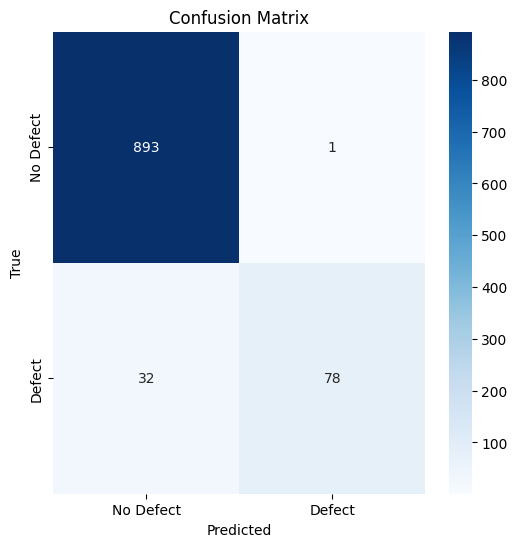

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models

# loading the fine-tuned model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)  # binary classification
model = model.to(device)

# loading saved model weights
model.load_state_dict(torch.load("/kaggle/working/fine_tuned_efficientnet.pth"))
model.eval()  #set the model to evaluation mode

true_labels = []
pred_labels = []

# running inference on the test set
with torch.no_grad():  #disabling gradient calculation for inference for more speed
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

        # getting our model's predictions
        outputs = model(inputs)
        preds = torch.sigmoid(outputs).round()  #rounding to 0 or 1
        
        # storing true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# flattening
true_labels = np.array(true_labels).flatten()
pred_labels = np.array(pred_labels).flatten()

# calculating the metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# here we plot our confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Defect', 'Defect'], yticklabels=['No Defect', 'Defect'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
